# Benign vs. Malignant moles
This dataset contains a balanced set (1440 benign and 1197 malignant mole images) of images of benign skin moles and malignant skin moles. Here, I have used fastai libraries to train a resnet model and determine if an image shows malignant mole or not. 

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
import pandas as pd 
import numpy as np
from fastai import *
from fastai.vision import *
from matplotlib import pyplot as plt
from google.colab import drive


In [3]:
drive.mount('/content/gdrive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [4]:
file_name = Path('/content/gdrive/My Drive/benign_vs_malignant/')
categories = os.listdir(file_name)
print(categories)

['benign', 'malignant', 'models']


In [0]:
verify_images(os.path.join(file_name, categories[1]), delete=True)

Here I will first resize all images to 256, keep aside 20% of data for validation, normalize the data as per the imagenet stat.

In [0]:
np.random.seed(42)
data = (ImageList.from_folder(file_name)
       .split_by_rand_pct(0.2)
       .label_from_folder()
       .transform(get_transforms(do_flip = True, flip_vert=False, max_lighting=0.2, max_zoom=1.05, max_warp=0.2), size=256)
       .databunch(bs=16)
       .normalize(imagenet_stats))

In [6]:
print(data.c)
print(data.classes)

2
['benign', 'malignant']


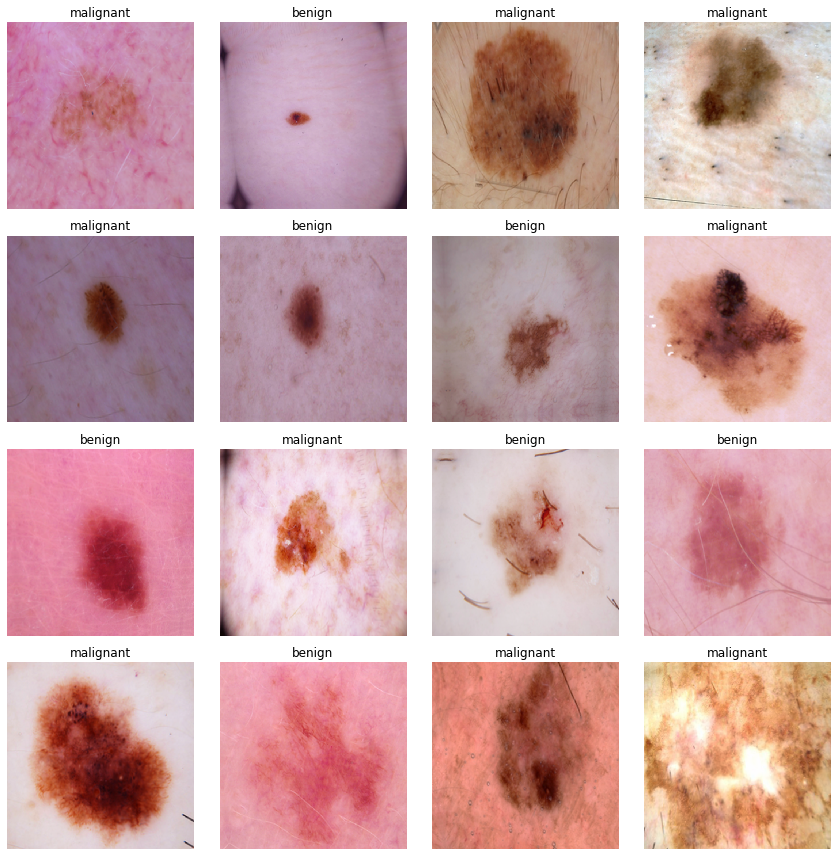

In [0]:
data.show_batch(rows=4, figsize=(12,12))

ResNet is abbreviation for Residual Network which is based on residual learning. In general, in a deep convolutional neural network, several layers are stacked and are trained to the task at hand. The network learns several low/mid/high level features at the end of its layers. In residual learning, instead of trying to learn some features, we try to learn some residual. Residual can be simply understood as subtraction of feature learned from input of that layer. ResNet does this using shortcut connections (directly connecting input of nth layer to some (n+x)th layer. It has proved that training this form of networks is easier than training simple deep convolutional neural networks and also the problem of degrading accuracy with increased number of layers is resolved. ResNet50 is a 50 layer Residual Network.

In [7]:
learn = cnn_learner(data, models.resnet50, metrics=accuracy)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 199MB/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 7.59E-07
Min loss divided by 10: 3.63E-04


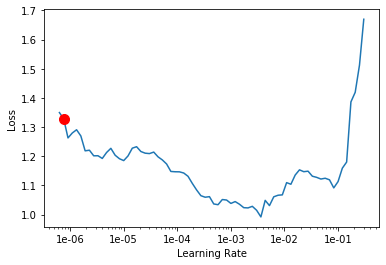

In [8]:
# learning rate optimization
learn.lr_find()
learn.recorder.plot(suggestion=True)

Here we train the model using fit_one_cycle for 10 epochs. By fitting one cycle, it would complete one cycle of learning rate, starting low, go up and then coming down. It trained the last layer and left the rest of the model as it was.

In [9]:
learn.fit_one_cycle(20, slice(1e-04))

epoch,train_loss,valid_loss,accuracy,time
0,0.936825,0.547944,0.760911,05:45
1,0.734266,0.447214,0.829222,00:49
2,0.702480,0.395058,0.857685,00:49
3,0.634338,0.384880,0.851992,00:49
4,0.595589,0.384669,0.870968,00:48
5,0.544974,0.352298,0.867173,00:48
6,0.497619,0.336303,0.869070,00:48
7,0.508332,0.311588,0.880455,00:49
8,0.491919,0.299909,0.874763,00:49
9,0.444819,0.293200,0.884250,00:49


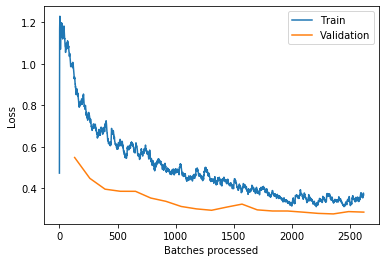

In [10]:
learn.recorder.plot_losses()

In [0]:
learn.save('stage_1')

In [0]:
learn = learn.load('stage_1')

## Progressive unfreezing

In [0]:
#learn.freeze_to(-2)

In [0]:
#learn.save('stage_2')

In [0]:
#learn = learn.load('stage_2')

In [0]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Failed to compute the gradients, there might not be enough points.


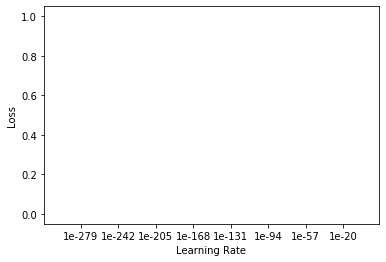

In [14]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [15]:
learn.fit_one_cycle(10, slice(1e-6, 1e-5))

epoch,train_loss,valid_loss,accuracy,time
0,0.335407,0.284034,0.882353,01:05
1,0.299760,0.287523,0.863378,01:05
2,0.340178,0.278742,0.869070,01:04
3,0.311617,0.277314,0.882353,01:05
4,0.339250,0.265778,0.880455,01:05
5,0.301512,0.257660,0.891841,01:05
6,0.315880,0.268187,0.880455,01:05
7,0.325445,0.270602,0.882353,01:05
8,0.282853,0.264909,0.884250,01:05
9,0.286053,0.261921,0.891841,01:05


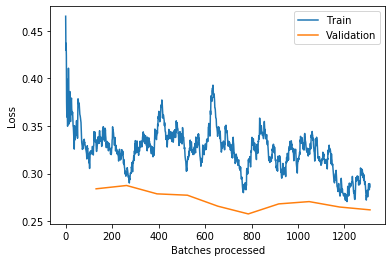

In [16]:
learn.recorder.plot_losses()

In [0]:
learn.save('stage_all')

In [0]:
learn = learn.load('stage_all')

In [0]:
train_interp = ClassificationInterpretation.from_learner(learn,ds_type=DatasetType.Train)
valid_interp = ClassificationInterpretation.from_learner(learn)

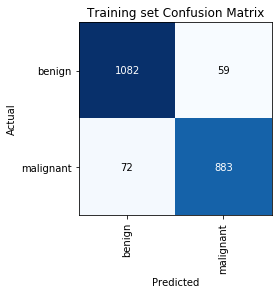

In [21]:
# Plot Training Set Confusion Matrix
train_interp.plot_confusion_matrix(title="Training set Confusion Matrix")

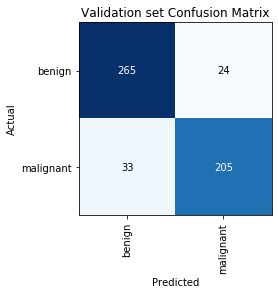

In [22]:
# Plot Validation Set Confusion Matrix
valid_interp.plot_confusion_matrix(title="Validation set Confusion Matrix")


In [0]:
losses,idxs = valid_interp.top_losses()

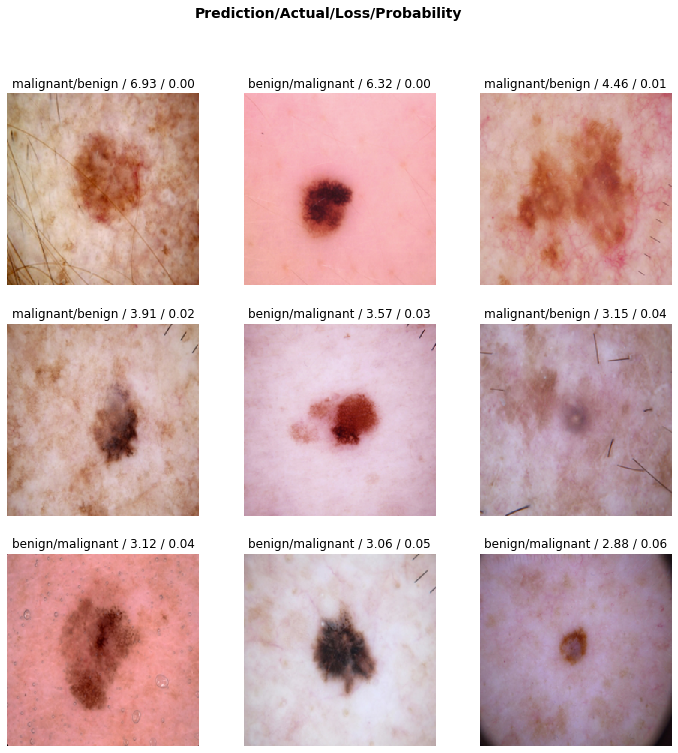

In [24]:
valid_interp.plot_top_losses(9)

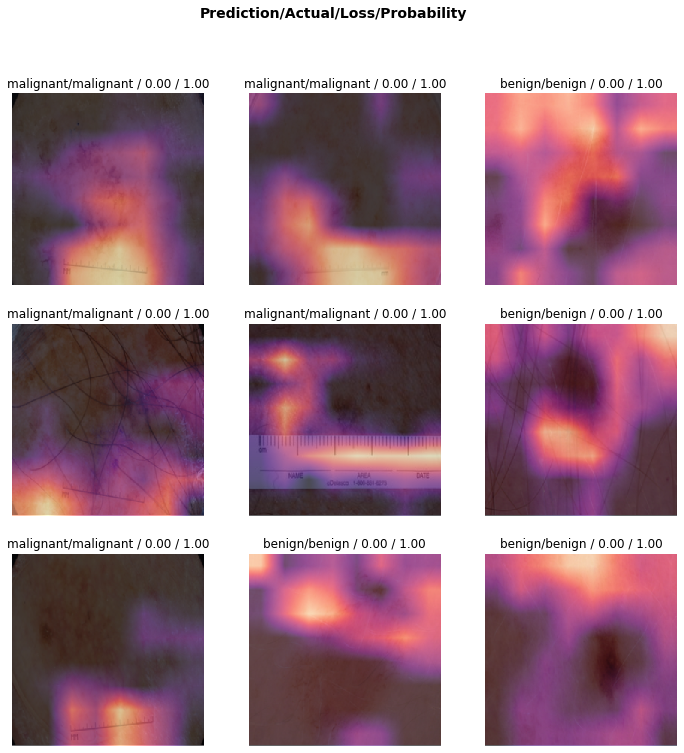

In [25]:
valid_interp.plot_top_losses(9, figsize=(12,12), largest=False, heatmap=True)

Next I applied progressive resizing, from 256 to 512. But the accuracy did not improve. I have to work on that further


In [0]:
np.random.seed(42)
data = (ImageList.from_folder(file_name)
       .split_by_rand_pct(0.2)
       .label_from_folder()
       .transform(get_transforms(do_flip = True, flip_vert=False, max_lighting=0.2, max_zoom=1.05, max_warp=0.2), size=512)
       .databunch(bs=8)
       .normalize(imagenet_stats))

In [27]:
learn.data = data
data.train_ds[0][0].shape

torch.Size([3, 512, 512])

In [0]:
learn.freeze()

In [29]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.32E-04
Min loss divided by 10: 6.31E-08


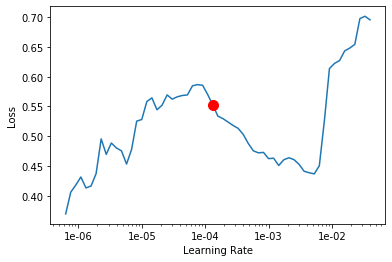

In [30]:
learn.recorder.plot(suggestion=True)

In [31]:
learn.fit_one_cycle(20, slice(1e-04))

epoch,train_loss,valid_loss,accuracy,time
0,0.476426,0.284924,0.878558,03:15
1,0.483237,0.296135,0.874763,03:10
2,0.446785,0.275336,0.884250,03:10
3,0.463982,0.261803,0.888046,03:10
4,0.458823,0.287130,0.869070,03:10
5,0.484692,0.269748,0.884250,03:10
6,0.457661,0.356107,0.829222,03:10
7,0.429871,0.258939,0.882353,03:10
8,0.399889,0.281640,0.880455,03:10
9,0.347894,0.266536,0.893738,03:10


In [32]:
learn.fit_one_cycle(10, slice(5e-04))

epoch,train_loss,valid_loss,accuracy,time
0,0.342227,0.251647,0.895636,03:13
1,0.379853,0.293065,0.884250,03:10
2,0.414314,0.364947,0.853890,03:10
3,0.365273,0.270869,0.891841,03:11
4,0.400449,0.242625,0.891841,03:10
5,0.312353,0.243227,0.889943,03:10
6,0.293944,0.250312,0.891841,03:11
7,0.316301,0.228893,0.893738,03:10
8,0.313838,0.226174,0.891841,03:10
9,0.296415,0.229349,0.901328,03:11


In [0]:
learn.save('stage-1_512')

In [0]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 9.12E-08


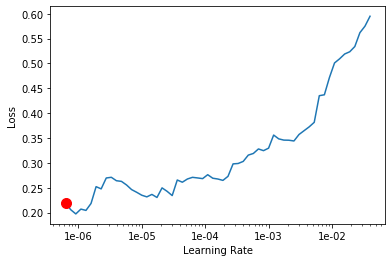

In [35]:
learn.lr_find()
learn.recorder.plot(suggestion=True)


In [36]:
learn.fit_one_cycle(10, slice(1e-06))

epoch,train_loss,valid_loss,accuracy,time
0,0.319141,0.234205,0.886148,04:12
1,0.285169,0.243732,0.888046,04:08
2,0.318341,0.229818,0.895636,04:12
3,0.286317,0.226678,0.893738,04:09
4,0.309525,0.235053,0.891841,04:12
5,0.270606,0.240206,0.888046,04:09
6,0.321271,0.225231,0.888046,04:12
7,0.300999,0.249125,0.886148,04:09
8,0.281463,0.234897,0.889943,04:12
9,0.265485,0.242295,0.888046,04:08
